In [1]:
import numpy as np
import pandas as pd
from pandas import read_excel
import matplotlib.pyplot as plt

In [56]:
df = read_excel('bank.xlsx')

In [57]:
df.head()

,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,.
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,.
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,.
3,409000611074',2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0,.
4,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0,.


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116201 entries, 0 to 116200
Data columns (total 9 columns):
Account No             116201 non-null object
DATE                   116201 non-null datetime64[ns]
TRANSACTION DETAILS    113702 non-null object
CHQ.NO.                905 non-null float64
VALUE DATE             116201 non-null datetime64[ns]
WITHDRAWAL AMT         53549 non-null float64
DEPOSIT AMT            62652 non-null float64
BALANCE AMT            116201 non-null float64
.                      116201 non-null object
dtypes: datetime64[ns](2), float64(4), object(3)
memory usage: 8.0+ MB


In [59]:
df.rename(columns={
    'DATE': 'start-date', 'VALUE DATE': 'end-date', 'DEPOSIT AMT': 'deposit-amt', 
    'BALANCE AMT': 'balance-amt', 'WITHDRAWAL AMT': 'withdrawal-amt', 'TRANSACTION DETAILS': 'details', 
    'Account No': 'account'}, inplace=True)
df['details'] = df['details'].astype(str)
df.tail()

,account,start-date,details,CHQ.NO.,end-date,withdrawal-amt,deposit-amt,balance-amt,.
116196,409000362497',2019-03-05,TRF TO 1196428 Indiaforensic SE,NaN,2019-03-05,117934.30,NaN,-1.901902e+09,.
116197,409000362497',2019-03-05,FDRL/INTERNAL FUND TRANSFE,NaN,2019-03-05,NaN,300000.0,-1.901602e+09,.
116198,409000362497',2019-03-05,FDRL/INTERNAL FUND TRANSFE,NaN,2019-03-05,NaN,300000.0,-1.901302e+09,.
116199,409000362497',2019-03-05,IMPS 05-03-20194C,NaN,2019-03-05,109868.65,NaN,-1.901412e+09,.
116200,409000362497',2019-03-05,Sweep Trf To: 40900036427,NaN,2019-03-05,5000.00,NaN,-1.901417e+09,.


2015-01-01 00:00:00
2019-03-05 00:00:00


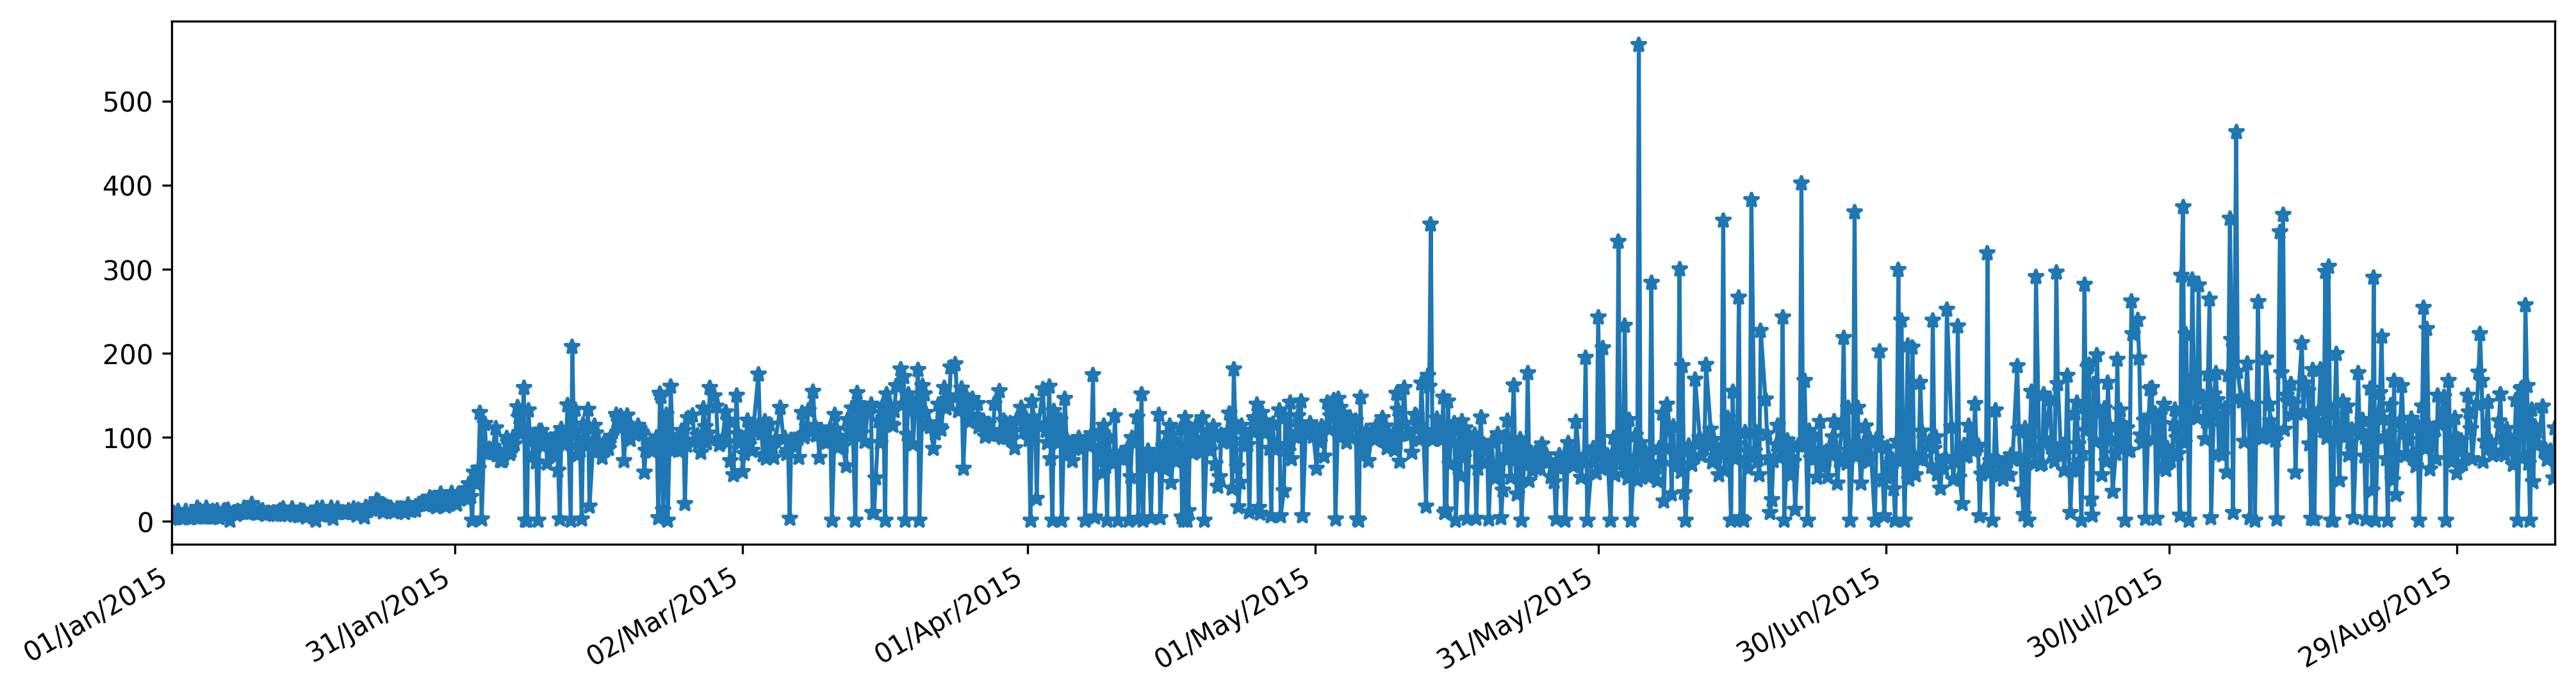

In [60]:
print(df['start-date'].min())
print(df['start-date'].max())
ax = plt.figure(figsize=(16,4), dpi=300).add_subplot(111)
xticks = pd.date_range(str(df['start-date'].min()), str(df['start-date'].max()), freq="30d")
df['start-date'].value_counts().plot(ax=ax, style='-*')
ax.set_xticklabels([x.strftime('%d/%h/%Y') for x in xticks]);

## Cleaning

In [61]:
print('Number of transactions where start-date != end-date: {}'.format(len(df) - np.sum(df['start-date'] == df['end-date'])))

Number of transactions where start-date != end-date: 135


Boa parte das transações possuem a mesma data de início, portanto podemos usar só uma delas. Agora, vamos verificar os caracteres do final de cada linha da coluna account.

In [62]:
sum([x[-1] == '\'' for x in df['account']]) == df.shape[0]

True

In [63]:
df['account'] = df['account'].map(lambda x: x[:-1] if x[-1] == '\'' else x);

In [64]:
list(map(lambda x: print(x + ': ', df.shape[0] - df.dropna(subset=[x]).shape[0]), df.columns));

account:  0
start-date:  0
details:  0
CHQ.NO.:  115296
end-date:  0
withdrawal-amt:  62652
deposit-amt:  53549
balance-amt:  0
.:  0


#### É possível notar uma grande quantidade de valores NA's na coluna CHQ.NO. Ela não será considerada na nossa análise. Além disso, serão removidas as colunas . e end-date (muito similar a start-date). Acredito que ano não contribuirá muito para a nossa análise, portanto não irei usá-lo.

#### Nota-se que withdrawal-amt + deposit-amt = 116201, o que indica que os eventos são mutuamente excludentes. Visto que o objetivo é prever o montante, podemos desconsiderar as linhas tal que withdrawal-amt = 0 para não desbalancear as classes.

In [65]:
df['balance-amt'].replace(np.nan, 0, inplace=True)
df.dropna(subset=['details'], inplace=True)
df.dropna(subset=['withdrawal-amt'], inplace=True)
df['account'] = df['account'].astype(np.int64)

df.loc[:, 'day'] = df['start-date'].dt.day
df.loc[:, 'month'] = df['start-date'].dt.month
df.drop(['start-date', 'end-date'], inplace=True, axis=1)
df.head()

,account,details,CHQ.NO.,withdrawal-amt,deposit-amt,balance-amt,.,day,month
10,409000611074,INDO GIBL Indiaforensic STL01071,NaN,133900.0,NaN,8366100.0,.,16,8
11,409000611074,INDO GIBL Indiaforensic STL02071,NaN,18000.0,NaN,8348100.0,.,16,8
12,409000611074,INDO GIBL Indiaforensic STL03071,NaN,5000.0,NaN,8343100.0,.,16,8
13,409000611074,INDO GIBL Indiaforensic STL04071,NaN,195800.0,NaN,8147300.0,.,16,8
14,409000611074,INDO GIBL Indiaforensic STL05071,NaN,81600.0,NaN,8065700.0,.,16,8


In [66]:
df_clean = df[['account', 'day', 'month', 'details', 'withdrawal-amt', 'balance-amt']].copy()
del df


## Distribuições 

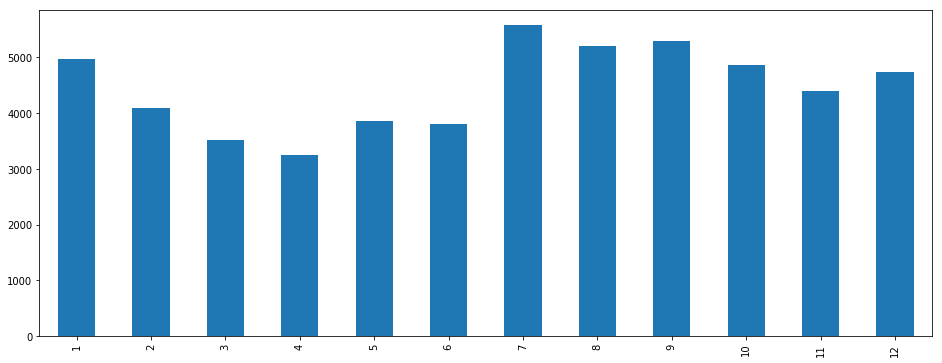

In [67]:
df_clean.groupby('withdrawal-amt').month.head(100000).value_counts(sort=False).plot(kind='bar', figsize=(16,6))

Acredito que mês seja uma boa feature, visto que temos diferentes distribuições para diferentes meses.

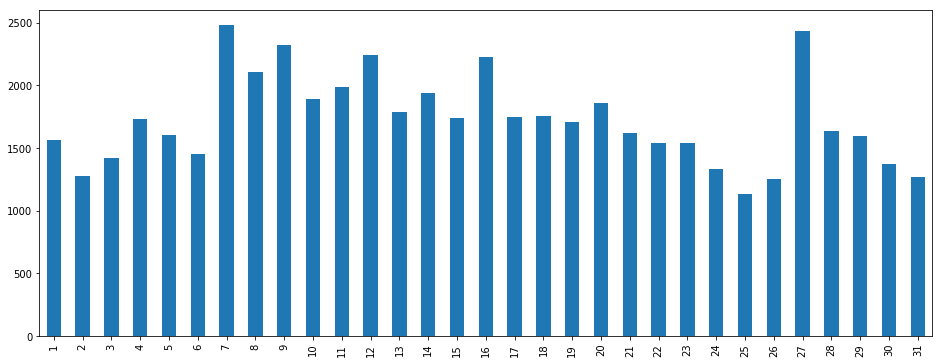

In [68]:
df_clean.groupby('withdrawal-amt').day.head(100000).value_counts(sort=False).plot(kind='bar', figsize=(16,6))

É possível notar que no início e fim do mês temos menor ocorrências de montantes retirados.

In [69]:
df_clean.shape

(53549, 6)

In [70]:
df_clean['withdrawal-amt'].value_counts()

15000000.00    4491
10000000.00    2497
5000000.00     1332
1000.00        1292
500.00         1276
1000000.00     1171
500000.00      1034
2000.00         994
10000.00        989
3000000.00      771
2000000.00      740
5000.00         739
3000.00         607
100.00          538
1500.00         381
4000.00         381
2500.00         373
300000.00       321
8000.00         288
4000000.00      288
200.00          285
200000.00       283
12000000.00     265
300.00          225
6000.00         221
8000000.00      205
9000.00         191
11800.00        177
400.00          172
7000.00         164
               ... 
222628.00         1
4129.00           1
6344836.81        1
1669.00           1
1609.00           1
255404.00         1
91000.00          1
628403.00         1
17590.00          1
1713.00           1
16100123.99       1
240.08            1
701.00            1
882010.46         1
26840.00          1
9004319.00        1
10761.92          1
1911981.00        1
49100.00          1


É necessário dropar as linhas cujos valores em withdrawal-amt ocorrem apenas uma vez para que o sklearn separe a porcentagem de exemplos nos conjuntos de treino e teste de forma igual (stratify em train_test_split), o comando usado seria:

```df_clean.groupby('withdrawal-amt').filter(lambda x: len(x) == 1)```.

In [71]:
df_clean.to_csv('clean.csv')

## Construindo o Modelo

Primeiro, vamos construir um modelo que funcionará como baseline para comparação. Para codificar o texto, foi usado tdfidf (max_features=10000 para manter uso de memória baixo) visto que é uma forma simples de codificar texto com bons resultados empíricos.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [73]:
X, y = df_clean.drop('withdrawal-amt', axis=1), df_clean['withdrawal-amt']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
del df_clean

In [74]:
tfidf = TfidfVectorizer(max_features=10000)

xtf_train = tfidf.fit_transform(xtrain.loc[:, 'details'])
xtf_test = tfidf.transform(xtest.loc[:, 'details'])

In [75]:
def predict(xtrain, ytrain, xtest, ytest):
    clf = LinearRegression(n_jobs=-1)
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xtest)
    print('Mean Absolute Error:', mean_absolute_error(ytest, ypred))  
    print('Mean Squared Error:', mean_squared_error(ytest, ypred))  
    return ypred

def plot(df):
    df.head(100).plot(kind='bar',figsize=(16,10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()

In [76]:
ypred = predict(xtf_train, ytrain, xtf_test, ytest)
df = pd.DataFrame({'Actual': ytest, 'Predicted': ypred})
df

Mean Absolute Error: 5375487.106713191
Mean Squared Error: 251084627838584.12


,Actual,Predicted
103931,148025.00,3.158820e+05
97191,449.00,4.714251e+03
14399,276023.00,1.301914e+07
99889,197643.03,2.839238e+06
72821,16880.00,6.032116e+05
16901,500.00,1.901855e+06
82281,500000.00,4.234851e+06
69257,10000000.00,4.234851e+06
34486,7564949.00,2.364172e+06
31286,15000000.00,1.158088e+07


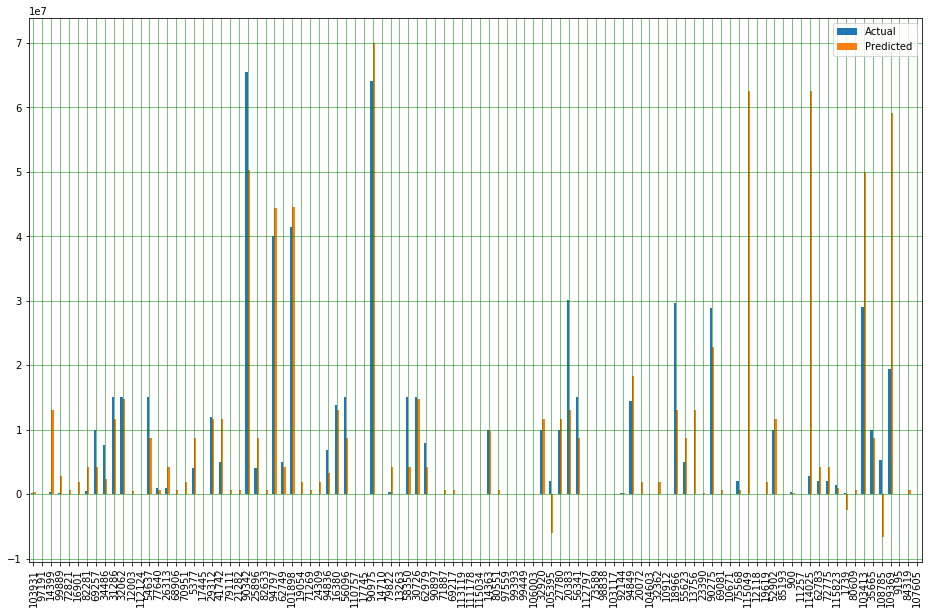

In [77]:
plot(df)

In [78]:
ypred = predict(xtrain.drop(['details'], axis=1), ytrain, xtest.drop(['details'], axis=1), ytest)
df = pd.DataFrame({'Actual': ytest, 'Predicted': ypred})
df

Mean Absolute Error: 5836110.321662099
Mean Squared Error: 124806875687144.84


,Actual,Predicted
103931,148025.00,6.201083e+06
97191,449.00,5.827005e+06
14399,276023.00,2.905372e+06
99889,197643.03,6.185100e+06
72821,16880.00,5.100633e+06
16901,500.00,2.471117e+06
82281,500000.00,5.811217e+06
69257,10000000.00,5.762003e+06
34486,7564949.00,5.416533e+06
31286,15000000.00,5.248572e+06


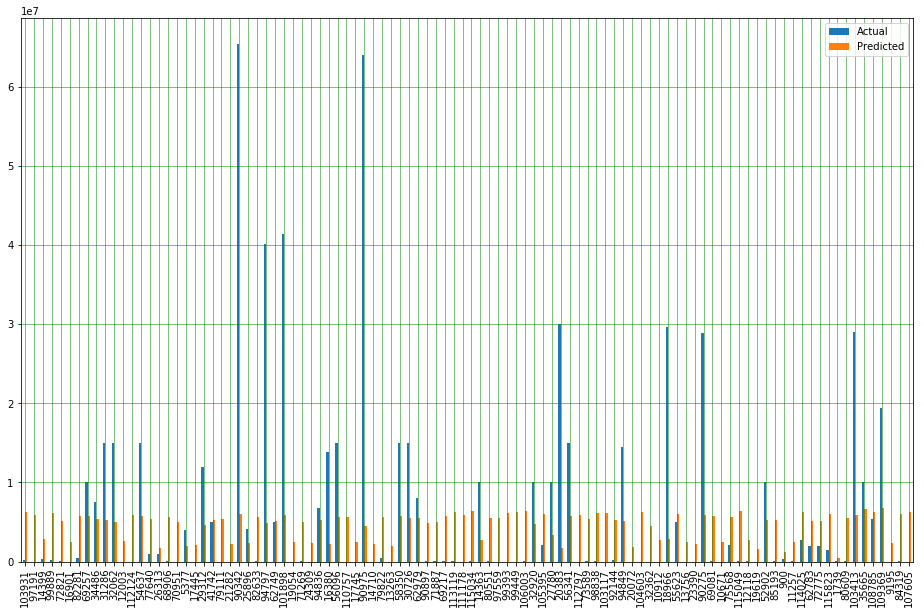

In [79]:
plot(df)

É possível notar que a feature "details" é uma feature mais importante para predição do montante usando Regressão Linear, visto que o erro usando apenas esta feature para treino foi bem menor.

## Modelo usando Redes Neurais

Primeiro é construído um modelo com base no tutorial [Classify structured data](https://www.tensorflow.org/beta/tutorials/keras/feature_columns). Em seguida, é construída uma LSTM convolucional customizada que não leva em conta a componente de tempo existente na layer do [Keras](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/ConvLSTM2D).

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Activation, DenseFeatures
from tensorflow.keras import layers, losses
from tensorflow import feature_column

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
list(map(lambda g: tf.config.experimental.set_memory_growth(g, True), gpus));


In [113]:
df_clean = pd.read_csv('clean.csv')
df_clean.drop('Unnamed: 0', inplace=True, axis=1)
df_clean.drop('details', inplace=True, axis=1)

In [6]:
def df_to_dataset(dataframe, labels='withdrawal-amt', shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop(labels)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [7]:
train, test = train_test_split(df_clean, test_size=0.3)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

29987 train examples
7497 validation examples
16065 test examples


In [8]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


In [9]:
example_batch = next(iter(train_ds))[0]


In [10]:
def demo(feature_column):
    feature_layer = DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())


In [11]:
demo(feature_column.numeric_column('month'))


[[11.]
 [ 7.]
 [ 9.]
 [ 5.]
 [ 7.]
 [ 9.]
 [ 5.]
 [12.]
 [11.]
 [ 9.]
 [ 6.]
 [ 7.]
 [ 6.]
 [ 2.]
 [ 2.]
 [12.]
 [12.]
 [ 2.]
 [ 7.]
 [ 7.]
 [ 3.]
 [ 1.]
 [10.]
 [ 7.]
 [ 9.]
 [ 5.]
 [ 9.]
 [10.]
 [ 2.]
 [ 6.]
 [ 4.]
 [10.]]


In [59]:
feature_columns = []

# numeric cols
feature_columns = list(map(lambda x: feature_column.numeric_column(x), ['account', 'day', 'month', 'balance-amt']))

In [13]:
def build_model(feature):
    model = Sequential([
        DenseFeatures(feature),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
        ])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

In [14]:
model = build_model(feature_columns)
model.fit(train_ds, validation_data=val_ds, epochs=10)
loss, mae = model.evaluate(test_ds)
print(mae)

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 138351382256853.9531 - mean_absolute_error: 4447599.6082 - val_loss: 120300077162809.7344 - val_mean_absolute_error: 4400567.0000
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 138351382256853.9531 - mean_absolute_error: 4447599.6082 - val_loss: 120300077162809.7344 - val_mean_absolute_error: 4400567.0000
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 138351382256853.9531 - mean_absolute_error: 4447599.6082 - val_loss: 120300077162809.7344 - val_mean_absolute_error: 4400567.0000
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 138351382256853.9531 - mean_absolute_error: 4447599.6082 - val_loss: 120300077162809.7344 - val_mean_absolute_error: 4400567.0000
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 138351382256853.9531 - mean_absolute_error: 4447599.6082 - val_loss: 120300077162809.7344 - val_mean_absolute_

##### Erro absoluto bem menor que o 5375487.106713191 obtido anteriormente.

## LSTM Convolucional

![LSTM](diagram.png)

LSTMs resolvem o problema de vanishing (e exploding) gradiente que faz com que redes recorrentes não se saiam tão bem em tarefas de long-term memory (não conseguem capturar dependências distantes devido ao pouco efeito de entradas anteriores na saída, pouca memória). Elas resolvem o problema criando um estado de memória interno que é simplesmente adicionado a entrada pré-processada, o que reduz bastante o efeito multiplicativo de gradientes pequenos (algumas camadas deixam de aprender se tiver gradientes pequenos). A dependência de tempo e o efeito de entradas anteriores são controladas pela forget gate, que determina quais estados devem ser lembrados ou esquecidos. 

## Primeiro, vamos definir a layer customizada da nossa LSTM convolucional. 

### Convolução
Uma rede neural convolucional é capaz de capturar depêndencias espaciais e temporais nos dados de forma bem-sucedida através da aplicação de filtros relevantes, dispensando a necessidade de engenharia de características. A arquitetura realiza um melhor ajuste ao conjunto de imagens devido à redução do número de parâmetros envolvidos e a reusabilidade dos pesos. Em outras palavras, a rede pode ser treinada para entender melhor a complexidade dos dados e suas características relevantes. Esta extração de características é feita por meio da aplicação de filtros (filtro é um termo que vem de processamento no domínio da frequência e se refere a aceitar ou rejeitar certos componentes de frequência) no domínio do espaço, denominados convoluções. Para uma máscara (filtro) de tamanho $m \times n$, $m = 2a + 1$ e $n = 2b + 1$, onde $a$ e $b$ são inteiros positivos e para um ponto $(x,\, y)$ qualquer na imagem $f$, a resposta do filtro é a soma dos produtos dos coeficientes do filtro e dos pixels da imagem englobados pelo filtro. A convolução é definida pela seguinte equação:
$$g(x,\, y) \,=\, \sum_{s\, =\, -a}^{a}\, \sum_{t\, =\, -b}^{b}w(s,t)f(x + s, y + t)$$
onde $w$ é o kernel do filtro. $x$ e $y$ variam de modo que cada pixel em $w$ visite todos os pixels em $f$.

### LSTM Gates
Na LSTM Convolucional implementada, primeiro é aplicada a convolução 2D na entrada com os parâmetros que foram definidos ao se construir a layer. O funcionamento dos portões baseia-se na formulação proposta por [Graves](https://arxiv.org/pdf/1308.0850.pdf). Esta formulação alternativa de uma LSTM é útil porque reduz o número de operações separadas necessárias para avaliar uma etapa, o que permite uma implementação eficiente na GPU. As funções de ativação aplicadas na input gate, forget gate, cell gate e output gate são, respectivamente: sigmoid, sigmoid, tanh e sigmoid. Aqui, inicialmente a entrada é somada com o $h_{t-1}$ (hidden state que será o output para $t$ anterior), em seguida é calculada a cell gate $s_t$ dado pela fórmula: $s_t = s_{t-1} \odot f + i \odot g$, onde $t$ indica o passo atual, $f$ a forget gate, $g$ a cell gate, e $i$ a input gate. O output final da layer para o passo $t$ atual é definido como: $h_t = o \odot tanh(st)$, onde $o$ é a output gate. Para resetar os estados, basta chamar o método reset_states que resetará cell_state e hidden_state. As layers implementadas são aplicadas em tensores para demonstração do funcionamento.




In [201]:
class CustomConv2DLSTM(tf.keras.layers.Layer):
    """ Implementação de uma camada Keras para uma LSTM que não leva em conta o componente de tempo 
    (pode-se definir um modelo com várias dessas layers).
    """
    def __init__(self, filters, kernel_size=3, strides=1, padding='same',
                 use_bias=True, h_kernel_size=1, name=None):
        self.filters = filters
        self.kwargs = {'filters': 4 * self.filters, 'kernel_size': kernel_size,
                       'strides': strides, 'padding': padding,
                       'use_bias': use_bias}
        self.h_kwargs = {'filters': 4 * self.filters,
                         'kernel_size': h_kernel_size, 'strides': 1,
                         'padding': padding, 'use_bias': use_bias}
        super(CustomConv2DLSTM, self).__init__(name=name)

    def get_config(self):
        config = self.kwargs.copy()
        config['filters'] = self.filters
        config['h_kernel_size'] = self.h_kwargs['kernel_size']
        config['name'] = self.name
        return config

    def reset_states(self):
        self.cell_state = tf.zeros_like(self.cell_state)
        self.hidden_state = tf.zeros_like(self.cell_state)

    def build(self, input_shape):
        """" Método responsável pela definição dos parâmetros iniciais da layer. """
        self.input_conv = tf.keras.layers.Conv2D(**self.kwargs)
        self.hidden_conv = tf.keras.layers.Conv2D(**self.h_kwargs)

        # Construir hidden e cell states
        out_tensor = self.input_conv(tf.zeros(input_shape))
        aux_gate = tf.split(out_tensor, 4, axis=3)[0]
        self.hidden_state = tf.zeros_like(aux_gate)
        self.cell_state = tf.zeros_like(aux_gate)

        self.stateful = True

        super(CustomConv2DLSTM, self).build(input_shape)

    def call(self, input):
        """ Implementação da lógica da LSTM """
        gates = self.input_conv(input) + self.hidden_conv(self.hidden_state)
        input_g, forget_g, cell_g, output_g = tf.split(gates, 4, axis=3)

        input_g = tf.math.sigmoid(input_g)
        forget_g = tf.math.sigmoid(forget_g)
        cell_g = tf.math.tanh(cell_g)
        output_g = tf.math.sigmoid(output_g)
        self.cell_state = (forget_g * self.cell_state) + (input_g * cell_g)
        self.hidden_state = output_g * tf.math.tanh(self.cell_state)

        return self.hidden_state

In [6]:
tensor = tf.random.uniform(shape=(64, 28, 28, 3))
params = {"filters": 32, "kernel_size": 3, "h_kernel_size": 1, "strides": 1, "padding": "same", 
          "use_bias": False}
lstm = CustomConv2DLSTM(**params)
lstm_out = lstm(tensor)

In [7]:
lstm_out

<tf.Tensor: id=70, shape=(64, 28, 28, 32), dtype=float32, numpy=
array([[[[ 2.45203488e-02, -2.52437312e-02, -1.86611060e-02, ...,
          -1.50504606e-02, -5.54490089e-03,  3.68036074e-03],
         [ 2.15355903e-02, -4.56260741e-02, -3.06544937e-02, ...,
          -2.37078704e-02,  1.21133728e-02, -8.17756820e-03],
         [ 3.44109274e-02, -2.53288839e-02, -3.35038081e-02, ...,
          -4.09822119e-03, -2.23286264e-02, -1.56987198e-02],
         ...,
         [ 1.97390188e-02, -3.29277106e-03, -1.44263310e-02, ...,
           2.11733882e-03, -7.59244524e-03, -6.55040890e-03],
         [-8.10211990e-04, -1.94338597e-02, -3.60475928e-02, ...,
          -1.31185278e-02, -1.53833237e-02,  1.73056265e-03],
         [ 1.25528257e-02,  3.79884313e-03, -1.78525187e-02, ...,
          -1.58536329e-03, -4.81447298e-03,  1.95460510e-03]],

        [[ 3.14635038e-02, -1.21285729e-02, -1.61586981e-02, ...,
           1.49107259e-02,  7.15144537e-03, -2.03656629e-02],
         [ 2.60911640e-

#### Vamos mudar para convolução em 1 dimensão e entrar com os dados com apenas um canal. Para isso é necessário ajustar o eixo ao se construir as gates e a operação das camadas input e hidden. Os dados não foram treinados e avaliados nesta última parte, visto que este não era o objetivo.

In [179]:
class CustomConv1DLSTM(tf.keras.layers.Layer):
    """ Implementação de uma camada Keras para uma LSTM que não leva em conta o componente de tempo 
    (pode-se definir um modelo com várias dessas layers).
    """
    def __init__(self, filters, kernel_size=3, strides=1, padding='same',
                 use_bias=True, h_kernel_size=1, name=None):
        self.filters = filters
        self.kwargs = {'filters': 4 * self.filters, 'kernel_size': kernel_size,
                       'strides': strides, 'padding': padding,
                       'use_bias': use_bias}
        self.h_kwargs = {'filters': 4 * self.filters,
                         'kernel_size': h_kernel_size, 'strides': 1,
                         'padding': padding, 'use_bias': use_bias}
        super(CustomConv1DLSTM, self).__init__(name=name)

    def get_config(self):
        config = self.kwargs.copy()
        config['filters'] = self.filters
        config['h_kernel_size'] = self.h_kwargs['kernel_size']
        config['name'] = self.name
        return config

    def reset_states(self):
        self.cell_state = tf.zeros_like(self.cell_state)
        self.hidden_state = tf.zeros_like(self.cell_state)

    def build(self, input_shape):
        self.input_conv = tf.keras.layers.Conv1D(**self.kwargs)
        self.hidden_conv = tf.keras.layers.Conv1D(**self.h_kwargs)

        # Construir hidden e cell states
        out_tensor = self.input_conv(tf.zeros(input_shape))
        aux_gate = tf.split(out_tensor, 4, axis=2)[0]
        self.hidden_state = tf.zeros_like(aux_gate)
        self.cell_state = tf.zeros_like(aux_gate)

        self.stateful = True

        super(CustomConv1DLSTM, self).build(input_shape)

    def call(self, input):
        gates = self.input_conv(input) + self.hidden_conv(self.hidden_state)
        input_g, forget_g, cell_g, output_g = tf.split(gates, 4, axis=2)

        input_g = tf.math.sigmoid(input_g)
        forget_g = tf.math.sigmoid(forget_g)
        cell_g = tf.math.tanh(cell_g)
        output_g = tf.math.sigmoid(output_g)
        self.cell_state = (forget_g * self.cell_state) + (input_g * cell_g)
        self.hidden_state = output_g * tf.math.tanh(self.cell_state)

        return self.hidden_state

In [180]:
import gc
gc.collect()

230

In [133]:
df_clean = pd.read_csv('clean.csv')
X, y = df_clean.drop('withdrawal-amt', axis=1), df_clean['withdrawal-amt']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)
del df_clean

In [181]:
xtrain_tensor = list(map(lambda x: tf.cast(tf.convert_to_tensor(xtrain[x]), np.float32), 
                         ['account', 'day', 'month', 'balance-amt']))
xval_tensor = list(map(lambda x: tf.cast(tf.convert_to_tensor(xval[x]), np.float32), 
                       ['account', 'day', 'month', 'balance-amt']))
xtest_tensor = list(map(lambda x: tf.cast(tf.convert_to_tensor(xtest[x]), np.float32), 
                        ['account', 'day', 'month', 'balance-amt']))
ytrain_tensor = tf.convert_to_tensor(ytrain)
yval_tensor = tf.convert_to_tensor(yval)
ytest_tensor = tf.convert_to_tensor(ytest)

In [182]:
xtrain_tensor = tf.concat([xtrain_tensor[0], xtrain_tensor[1], xtrain_tensor[2], xtrain_tensor[3]], axis=0)
xval_tensor = tf.concat([xval_tensor[0], xval_tensor[1], xval_tensor[2], xval_tensor[3]], axis=0)
xtest_tensor = tf.concat([xtest_tensor[0], xtest_tensor[1], xtest_tensor[2], xtest_tensor[3]], axis=0)

In [183]:
xtrain_tensor.shape, xval_tensor.shape, xtest_tensor.shape

(TensorShape([119948]), TensorShape([29988]), TensorShape([64260]))

In [184]:
np.prod(xtrain_tensor.shape)//64, np.prod(xval_tensor.shape)//64, np.prod(xtest_tensor.shape)//64

(1874, 468, 1004)

In [185]:
np.sqrt(1874), np.sqrt(468), np.sqrt(1004)

(43.289721643826724, 21.633307652783937, 31.68595903550972)

In [186]:
batch_size = 64

# Precisamos fazer com que dimensão 1 e 2 dos tensores seja múltipla de 4 para a nossa LSTM
xtrain_tensor = tf.reshape(xtrain_tensor[:batch_size*40*40], [batch_size, 40, 40])
xval_tensor = tf.reshape(xval_tensor[:batch_size*20*20], [batch_size, 20, 20])
xtest_tensor = tf.reshape(xtest_tensor[:batch_size*28*28], [batch_size, 28, 28])

In [187]:
tf.reshape(xtrain_tensor, [-1])

<tf.Tensor: id=1266, shape=(102400,), dtype=float32, numpy=
array([ 4.0900038e+11,  1.1964280e+06,  1.1964280e+06, ...,
       -1.6880595e+09, -1.5354836e+09, -1.7119316e+09], dtype=float32)>

In [188]:
params = {"filters": 88, "kernel_size": 3, "h_kernel_size": 1, "strides": 1, "padding": "same", "use_bias": False}

lstm = CustomConv1DLSTM(**params)

lstm(xtrain_tensor)

<tf.Tensor: id=1345, shape=(64, 40, 88), dtype=float32, numpy=
array([[[ 0.       ,  0.       , -0.       , ...,  0.       ,
          0.       , -0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
         -0.       , -0.7615942],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       , -0.7615942],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
         -0.       , -0.7615942],
        [ 0.       ,  0.       ,  0.7615942, ...,  0.       ,
          0.       , -0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.7615942, -0.7615942]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
         -0.       , -0.       ],
        [ 0.       ,  0.       ,  0.7615942, ...,  0.       ,
         -0.7615942, -0.7615942],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
         -0.       , -0.7615942],
        ...,
        [ 0.       ,  0.       , -0.       , 

In [199]:
Dense(1, activation='sigmoid')(lstm(xtrain_tensor))

<tf.Tensor: id=1778, shape=(64, 40, 1), dtype=float32, numpy=
array([[[0.45078683],
        [0.3784493 ],
        [0.35629946],
        ...,
        [0.3875839 ],
        [0.6681147 ],
        [0.66286623]],

       [[0.5678013 ],
        [0.703189  ],
        [0.39460757],
        ...,
        [0.5346467 ],
        [0.3981211 ],
        [0.49726576]],

       [[0.56868535],
        [0.6465214 ],
        [0.5167624 ],
        ...,
        [0.6219541 ],
        [0.5404698 ],
        [0.7137247 ]],

       ...,

       [[0.493476  ],
        [0.43199867],
        [0.40629023],
        ...,
        [0.48737064],
        [0.50145197],
        [0.20471355]],

       [[0.41266683],
        [0.42159408],
        [0.36528462],
        ...,
        [0.5413091 ],
        [0.4234494 ],
        [0.3147022 ]],

       [[0.25335437],
        [0.3827957 ],
        [0.4532195 ],
        ...,
        [0.39484543],
        [0.5167077 ],
        [0.33461168]]], dtype=float32)>